<a href="https://colab.research.google.com/github/skashyapsri/Absorbance-Prediction-Using-ML/blob/main/Numerical_Deconvolution_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check spectra...
Apply pigment filter...
Call deconvolution function...
Executing deconvolution...
Shape of X: (331,)
Shape of EPS_REF: (331, 8)
Shape of ABS_EVOO: (331,)
Shape of MW: (8,)
Computing the overlap matrix...
Diagonalizing the overlap matrix...
Computing eigenvectors for the new base ...
(331, 8)
Computing SV coefficients...
Computing pigments' concentrations...

Reconstructing deconvolved spectrum and calculating residues ...
Final results: AUTO FITTING
R-square = 0.999042
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = ********* mg/kg
Pheo-a       =    10.755 mg/kg
Pheo-b       =     1.935 mg/kg
b-CAR        =     2.983 mg/kg
LUT          =     4.953 mg/kg
NEX          =    -0.052 mg/kg
Chl-a        =    -0.022 mg/kg
Chl-b        =     0.869 mg/kg
-------------------------------
PIGMENT TOTAL =    21.421 mg/kg
Plotting deconvolution results...


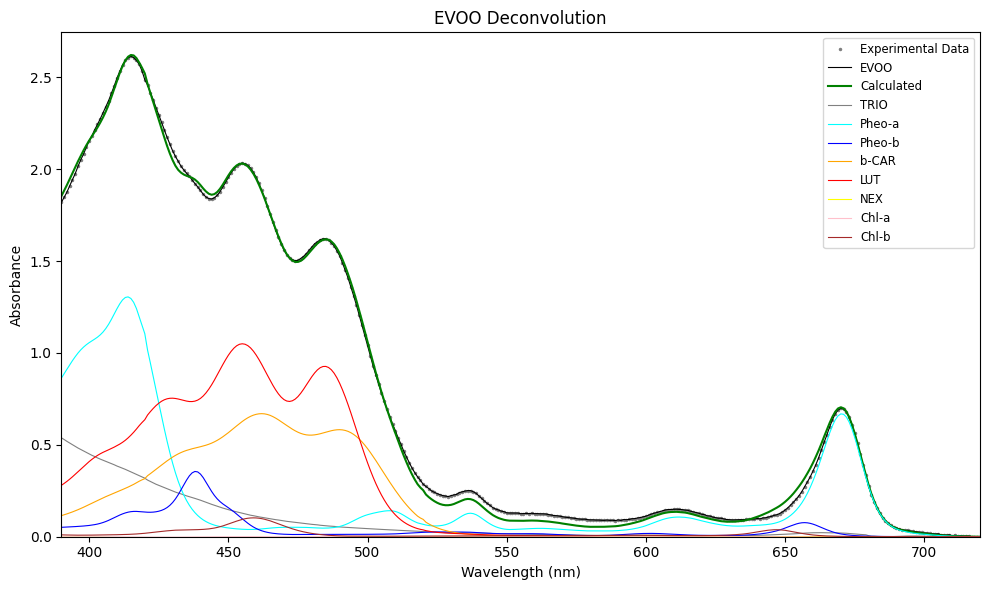

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

evoo_samples = pd.read_csv('https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/evoo_test.csv', delimiter=';')
pigments_data = pd.read_csv('https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/pigments/pigments.csv', delimiter=';', comment='#')
evoo_samples.columns = ['Wavelength', 'Absorbance']
pigments_data = pigments_data.rename(columns={'Wavelength (nm)': 'Wavelength'})

EVOO_DENSITY = 0.91
COLORS = ['gray', 'cyan', 'blue', 'orange', 'red', 'yellow',
              'pink', 'brown']

def processSpectra(evoo_samples, pigments_data):
    X_EVOO = evoo_samples['Wavelength'].values
    ABS_EVOO = evoo_samples['Absorbance'].values

    X_REF = pigments_data['Wavelength'].values[2:]
    X_REF = X_REF.astype(float)
    EPS_REF = pigments_data.iloc[2:, 1:].astype(float).values

    min_wavelength = max(X_EVOO.min(), X_REF.min())
    max_wavelength = min(X_EVOO.max(), X_REF.max())

    evoo_mask = (X_EVOO >= min_wavelength) & (X_EVOO <= max_wavelength)
    ref_mask = (X_REF >= min_wavelength) & (X_REF <= max_wavelength)

    X_EVOO = X_EVOO[evoo_mask]
    ABS_EVOO = ABS_EVOO[evoo_mask]
    X_REF = X_REF[ref_mask]
    EPS_REF = EPS_REF[ref_mask]

    f = interpolate.interp1d(X_EVOO, ABS_EVOO, kind='cubic', fill_value='extrapolate')
    ABS_EVOO_interp = f(X_REF)

    return X_REF, EPS_REF, X_REF, ABS_EVOO_interp

def plot(X_EVOO, ABS_EVOO, FILTER, X_REF, EPS_REF, ABS_CALC=None, ABS_CALC_CONTR=None):
    fig = plt.figure(figsize=(10, 6), dpi=100)  # Increased figure size for better legend visibility
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.title('EVOO Deconvolution')
    plt.xlim(np.min(X_EVOO), np.max(X_EVOO))
    plt.ylim(0, np.max(ABS_EVOO)+np.max(ABS_EVOO)*0.05)

    EXP = ABS_EVOO

    plt.plot(X_EVOO, EXP, '.', markersize=3, color='gray', label='Experimental Data')
    if len(X_REF):
        plt.plot(X_REF, ABS_EVOO, '-k', linewidth=0.8, label='EVOO')

    if ABS_CALC is not None and len(ABS_CALC) > 0:
        plt.plot(X_REF, ABS_CALC, '-g', label='Calculated')
        PIGMENTS = pigments_data.columns[1:].tolist()
        for i in range(len(PIGMENTS)):
            plt.plot(X_REF, ABS_CALC_CONTR[:, i], linewidth=0.8, color=COLORS[i],
                     label=f'{PIGMENTS[i]}')

    plt.legend(loc='best', fontsize='small')  # Add legend with automatic positioning
    plt.tight_layout()
    plt.show()

def deconvolve(X, EPS_REF, ABS_EVOO, MW):
    print("Executing deconvolution...")
    print(f"Shape of X: {X.shape}")
    print(f"Shape of EPS_REF: {EPS_REF.shape}")
    print(f"Shape of ABS_EVOO: {ABS_EVOO.shape}")
    print(f"Shape of MW: {MW.shape}")

    N_PIGMENTS = np.shape(EPS_REF)[1]
    print("Computing the overlap matrix...")
    ovlp = np.zeros((N_PIGMENTS, N_PIGMENTS))
    for i in range(N_PIGMENTS):
        for j in range(i, N_PIGMENTS):
            prod = np.multiply(EPS_REF[:, i], EPS_REF[:, j])
            ovlp[i, j] = np.trapz(prod, X[::-1])
    ovlp = ovlp+ovlp.T-np.eye(N_PIGMENTS)*np.diag(ovlp)

    print("Diagonalizing the overlap matrix...")
    eigval, eigvec = np.linalg.eigh(ovlp, UPLO='U')

    check = np.where(eigval == 0)[0]
    if (len(check) > 0):
        msg = "\nError!\n%d eigenvalues are zero\nDeconvolution is not possibile!\n" % len(
            check)
        print(msg)
        return np.zeros(N_PIGMENTS)

    print("Computing eigenvectors for the new base ...")
    print(np.shape(EPS_REF))
    base = np.einsum('ri,jr->ji', eigvec, EPS_REF)

    print("Computing SV coefficients...")
    gamma = np.zeros(N_PIGMENTS)
    for i in range(N_PIGMENTS):
        gamma[i] = -np.trapz(base[:, i]*ABS_EVOO/eigval[i], X)

    print("Computing pigments' concentrations...")
    concmol = np.einsum('k,ik->i', gamma, eigvec)

    return concmol


def printResults(ABS_EVOO, ABS_CALC, PIGMENTS, concppm, txt):
    # R^2 fitting
    ave = np.average(ABS_EVOO)
    Rsq = 1 - np.sum((ABS_EVOO - ABS_CALC)**2) / np.sum((ABS_EVOO - ave)**2)

    print(f'Final results: {txt}')
    print(f'R-square = {Rsq:.6f}')
    print('    PIGMENT CONCENTRATION')
    print('-------------------------------')
    for pigment, conc in zip(PIGMENTS, concppm):
        if conc > 1e4:
            print(f'{pigment:12s} = ********* mg/kg')
        else:
            print(f'{pigment:12s} = {conc:9.3f} mg/kg')
    print('-------------------------------')
    total_conc = np.sum(concppm[concppm < 1e4])
    print(f'PIGMENT TOTAL = {total_conc:9.3f} mg/kg')

print("Check spectra...")
X_REF, EPS_REF, X_EVOO, ABS_EVOO = processSpectra(evoo_samples, pigments_data)

print("Apply pigment filter...")
PIGMENTS = pigments_data.columns[1:].tolist()
MW = pigments_data.iloc[0, 1:].astype(float).values
FILTER = np.ones(len(PIGMENTS), dtype=bool)

print("Call deconvolution function...")
try:
    concmol = deconvolve(X_REF, EPS_REF, ABS_EVOO, MW)
    concppm = concmol * MW * 1000 / EVOO_DENSITY

    print("\nReconstructing deconvolved spectrum and calculating residues ...")
    ABS_CALC_CONTR = EPS_REF*concmol
    ABS_CALC = np.einsum('ik,k->i', EPS_REF, concmol)

    printResults(ABS_EVOO, ABS_CALC, PIGMENTS, concppm, 'AUTO FITTING')

    print("Plotting deconvolution results...")
    plot(X_EVOO, ABS_EVOO, FILTER, X_REF, EPS_REF, ABS_CALC, ABS_CALC_CONTR)



except ValueError as e:
    print(f"An error occurred during deconvolution: {e}")
    print("Plotting original data without deconvolution...")
    plot(X_EVOO, ABS_EVOO, FILTER, X_REF, EPS_REF)